In [2]:
import numpy as np

In [3]:
k0 = 1.37
L0 = 1.0

r1 = np.array([0.1, -0.4])
r2 = np.array([1.0, 2.0])

dr = r2 - r1

# r1 = me, r2 = other mass
getSpringForce = lambda r1, r2: k0*(1 - L0/np.sqrt(np.sum((r2 - r1)**2)))*(r2 - r1)

print(getSpringForce)

<function <lambda> at 0x7faffbfad700>


In [4]:
eps = 1e-12
# vec = np.array([1,0])
vec = (r2 - r1) / np.linalg.norm(r1-r2)
print(np.imag(getSpringForce(r1, r2 + eps*vec*1j))/eps)

# vec = np.array([1,0])
# print(np.imag(getSpringForce(np.array([1,0]), np.array([4,0]) + eps*vec*1j))/eps)

[0.48103911 1.28277097]


In [5]:
def compute_fd(f, r1, r2, vec):
    eps = 1e-13
    return np.imag(f(r1, r2+eps*vec*1j))/eps

jac = np.c_[(
    compute_fd(getSpringForce, r1, r2, np.array([1,0])),
    compute_fd(getSpringForce, r1, r2, np.array([0,1])))]

print(vec.T@jac)
print(compute_fd(getSpringForce, r1, r2, vec))

ax_vec = (r2-r1)/np.linalg.norm(r2-r1)
print(np.linalg.norm(ax_vec.T@jac))

[0.48103911 1.28277097]
[0.48103911 1.28277097]
1.37


In [6]:
def getSpringForcesOnMass(r1, r2, r3):
    return getSpringForce(r2,r1) + getSpringForce(r2,r3)
    

# getSpringForcesOnMass(np.array([0.,0.]), np.array([1.0,0.0]), np.array([2.0,0.]))

r1 = np.random.uniform(size=(2))
r2 = np.random.uniform(size=(2))
r3 = np.random.uniform(size=(2))

ax_vec1 = (r2-r1)/np.linalg.norm(r2-r1)
ax_vec3 = (r2-r3)/np.linalg.norm(r2-r3)

def compute_fd_1(f, r1, r2, r3, vec):
    eps = 1e-13
    return np.imag(f(r1+eps*vec*1j, r2, r3))/eps

def compute_fd_2(f, r1, r2, r3, vec):
    eps = 1e-13
    return np.imag(f(r1, r2+eps*vec*1j, r3))/eps

def compute_fd_3(f, r1, r2, r3, vec):
    eps = 1e-13
    return np.imag(f(r1, r2, r3+eps*vec*1j))/eps

print(np.linalg.norm(compute_fd_1(getSpringForcesOnMass, r1, r2, r3, ax_vec1)))
print(np.linalg.norm(compute_fd_3(getSpringForcesOnMass, r1, r2, r3, ax_vec3)))


1.37
1.3700000000000003


In [15]:
B = 10

def getJacobian(r1,r2,r3):
    return np.stack(
        (
            compute_fd_1(getSpringForcesOnMass, r1, r2, r3, np.array([1,0])),
            compute_fd_1(getSpringForcesOnMass, r1, r2, r3, np.array([0,1])),
            compute_fd_2(getSpringForcesOnMass, r1, r2, r3, np.array([1,0])),
            compute_fd_2(getSpringForcesOnMass, r1, r2, r3, np.array([0,1])),
            compute_fd_3(getSpringForcesOnMass, r1, r2, r3, np.array([1,0])),
            compute_fd_3(getSpringForcesOnMass, r1, r2, r3, np.array([0,1])),
        )
    ).T

def getDs1(r1,r2,r3):
    return (r1-r2) / np.linalg.norm(r1-r2)

def getDs3(r1,r2,r3):
    return (r3-r2) / np.linalg.norm(r3-r2)

jacList = []
s1List = []
s3List = []
out1List = []
out3List = []

for _ in range(B):
    r1 = np.random.uniform(size=(2))
    r2 = np.random.uniform(size=(2))
    r3 = np.random.uniform(size=(2))
    jac = getJacobian(r1,r2,r3)
    ds1 = getDs1(r1,r2,r3)
    ds3 = getDs3(r1,r2,r3)
    jacList.append(jac)
    s1List.append(ds1)
    s3List.append(ds3)
    out1List.append(ds1.T@jac[:,:2])
    out3List.append(ds3.T@jac[:,4:])


# print(getJacobian(r1,r2,r3))
jacList = np.stack(jacList)
s1List = np.stack(s1List)
s3List = np.stack(s3List)
out1List = np.stack(out1List)
out3List = np.stack(out3List)
print(jacList.shape)
print(s1List.shape)
print(s3List.shape)

print("Einsum matches j-v products for first spring:", np.allclose(np.einsum('ijk,ik->ij', jacList[:,:,:2], s1List), out1List))
print("Einsum matches j-v products for second spring:", np.allclose(np.einsum('ijk,ik->ij', jacList[:,:,4:], s3List), out3List))

print("The jacobian-vector product norms should be exactly equal to the spring constant, k0:")
print("k0 =", k0)
print(np.sqrt(np.sum(np.einsum('ijk,ik->ij', jacList[:,:,:2], s1List)**2, axis=1)))
print(np.sqrt(np.sum(np.einsum('ijk,ik->ij', jacList[:,:,4:], s3List)**2, axis=1)))


(10, 2, 6)
(10, 2)
(10, 2)
Einsum matches j-v products for first spring: True
Einsum matches j-v products for second spring: True
The jacobian-vector product norms should be exactly equal to the spring constant, k0:
k0 = 1.37
[1.37 1.37 1.37 1.37 1.37 1.37 1.37 1.37 1.37 1.37]
[1.37 1.37 1.37 1.37 1.37 1.37 1.37 1.37 1.37 1.37]


In [8]:
np.save("jac.npy", jacList)
np.save("s1.npy", s1List)
np.save("s2.npy", s3List)
np.save("out1.npy", out1List)
np.save("out2.npy", out3List)

In [ ]:
from scipy.integrate import solve_ivp

def getqdot(x, xdot, model):
    # x0 = np.array(N_m, 1)
    # forces = np.array(N_m, 1)
    N_m = x.shape[0]
    forces = model.forward(x)
    # forces = model(x)
    q0 = np.concatenate((x, xdot))
    qdot = np.concatenate((xdot, forces))
    return qdot

def compute_trajectory(x0, x0dot, model):
    N_m = x0.shape[0]
    q0 = np.concatenate((x0, x0dot))
    sol = solve_ivp(lambda t, q: getqdot(q[:N_m], q[N_m:], model), [0,10], y0=q0, t_eval=np.linspace(0,10,101))
    y = sol.y
    t = sol.t
    return y, t

N_m = 2
# x0 = np.array([-1.0, 1.0])
# x0dot = np.zeros(2)
# model = lambda x: np.array([(x[1]-x[0]), (x[0]-x[1])])

y, t = compute_trajectory(x0,x0dot,model)

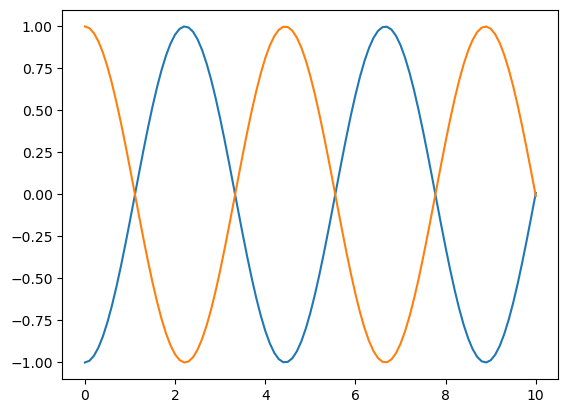

In [36]:
import matplotlib.pyplot as plt

plt.plot(t, y.T[:,:N_m])